In [1]:
# Initial Set-Up
import numpy as np
import pandas as pd
import requests
import psycopg2
import matplotlib.pyplot as plt
import json
import seaborn as sns
import api_keys
from api_keys import FBI_api_key, BLS_api_key
import passwords
from passwords import password
import csv

##### 1.  Create a data model with at least two tables in lucidchart.



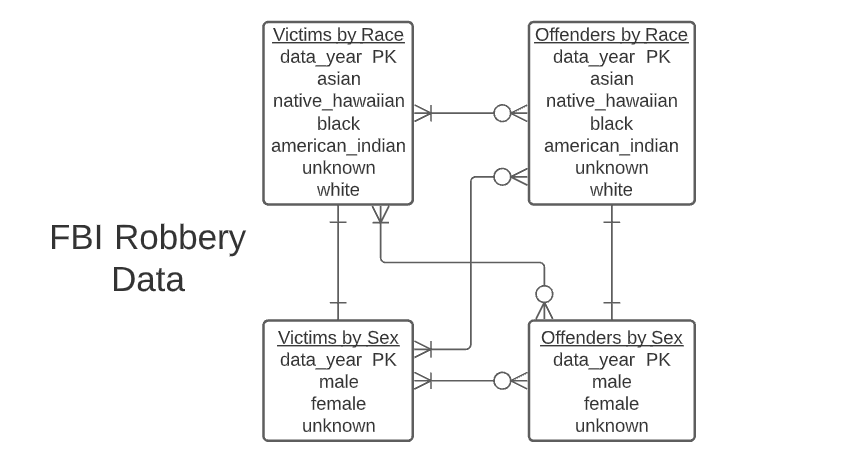

Since every victim has both a sex and a race (especially since the tables allow for unknown), there is one-to-one mandatory relationship beween the victim tables.  The same is true for the relationship between the two offender tables.

As for victims as they relate to offenders, the relationship is one-to-many in either direction.  Each offender in the database could be tied to one or many victims, and each victim in the database could be tied to one or many offenders.  

Since the offender may or may not be known and present in the database, the relationship from victim to offender is optional.  However, since the victim is always known in order for the robbery to be reported, the relationship from offender to victim is mandatory. 

##### 2.  Create a DDL for each table and execute it programatically.



In [2]:
# Offender Data by Race
base_url_1 = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/robbery/offender/national/race/?limit=1&api_key="
response1=requests.get(base_url_1+FBI_api_key)
r_offender_data=json.loads(response1.text)
r_offender_data_df=pd.DataFrame(r_offender_data["results"])

# Add 'offenders' to column headings in anticipation of future joins
new_cols=[]
for i in range(len(r_offender_data_df.columns)-1):
    string = r_offender_data_df.columns[i]+'_offenders'
    new_cols.append(string)
new_cols.append('data_year')
r_offender_data_df.columns = new_cols

r_offender_data_df.head()

,asian_offenders,native_hawaiian_offenders,black_offenders,american_indian_offenders,unknown_offenders,white_offenders,data_year
0,50,0,10787,37,954,3760,1996
1,144,0,30200,82,3560,11462,2000
2,400,0,83646,284,7246,27467,2007
3,467,0,73183,497,8000,27320,2012
4,580,0,61809,618,8932,29068,2017


In [3]:
# Offender Data by Sex
base_url_2 = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/robbery/offender/national/sex/?limit=1&api_key="
response2=requests.get(base_url_2+FBI_api_key)
s_offender_data=json.loads(response2.text)
s_offender_data_df=pd.DataFrame(s_offender_data["results"])


# Add 'offenders' to column headings in anticipation of future joins
new_cols=[]
for i in range(len(s_offender_data_df.columns)-1):
    string = s_offender_data_df.columns[i]+'_offenders'
    new_cols.append(string)
new_cols.append('data_year')
s_offender_data_df.columns = new_cols

s_offender_data_df.head()

,male_count_offenders,female_count_offenders,unknown_offenders,data_year
0,14004,1002,582,1996
1,39855,2990,2603,2000
2,106207,8783,4053,2007
3,94975,9579,4913,2012
4,84404,11426,5223,2017


In [4]:
# Victim Data by Race
base_url_3 = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/robbery/victim/national/race/?limit=1&api_key="
response3=requests.get(base_url_3+FBI_api_key)
r_victim_data=json.loads(response3.text)
r_victim_data_df=pd.DataFrame(r_victim_data["results"])
r_victim_data_df.head()

# Add 'victims' to column headings in anticipation of future joins
new_cols=[]
for i in range(len(r_victim_data_df.columns)-1):
    string = r_victim_data_df.columns[i]+'_victims'
    new_cols.append(string)
new_cols.append('data_year')
r_victim_data_df.columns = new_cols

r_victim_data_df.head()

,asian_victims,native_hawaiian_victims,black_victims,american_indian_victims,unknown_victims,white_victims,data_year
0,132,0,4236,18,315,7843,1996
1,629,0,12196,120,1078,22467,2000
2,2194,0,30172,398,2281,49318,2012
3,2449,0,26227,667,2681,49487,2017
4,2,0,134,1,9,172,2005


In [5]:
# Victim Data by Sex
base_url_4 = "https://api.usa.gov/crime/fbi/sapi/api/data/nibrs/robbery/victim/national/sex/?limit=1&api_key="
response4=requests.get(base_url_4+FBI_api_key)
s_victim_data=json.loads(response4.text)
s_victim_data_df=pd.DataFrame(s_victim_data["results"])
s_victim_data_df.head()

# Add 'victims' to column headings in anticipation of future joins
new_cols=[]
for i in range(len(s_victim_data_df.columns)-1):
    string = s_victim_data_df.columns[i]+'_victims'
    new_cols.append(string)
new_cols.append('data_year')
s_victim_data_df.columns = new_cols

s_victim_data_df.head()

,male_count_victims,female_count_victims,unknown_victims,data_year
0,8342,4166,36,1996
1,24249,12031,210,2000
2,55596,28577,190,2012
3,53024,28335,234,2017
4,213,102,3,2005


In [6]:
# Create CSVs
r_offender_data_df.to_csv('r_offenders.csv', index=False)
s_offender_data_df.to_csv('s_offenders.csv', index=False)
r_victim_data_df.to_csv('r_victims.csv', index=False)
s_victim_data_df.to_csv('s_victims.csv', index=False)

##### 3.  Load your data using psycopg2 or another module.

In [7]:
# Table Creation

conn = psycopg2.connect(host='localhost', dbname='crime_data', user='postgres', password = password)   # Connect to Postgres

cur = conn.cursor()

#Offenders by Race
# ...just to avoid duplicating tables as I troubleshoot my code
cur.execute("DROP TABLE IF EXISTS obr")
conn.commit()
        
cur.execute("""CREATE TABLE obr(
            asian_offenders integer, 
            native_hawaiian_offenders integer, 
            black_offenders integer, 
            american_indian_offenders integer, 
            unknown_offenders integer, 
            white_offenders integer,
            data_year integer PRIMARY KEY
)""")
conn.commit()
                            
#Offenders by Sex
# ...just to avoid duplicating tables as I troubleshoot my code
cur.execute("DROP TABLE IF EXISTS obs")
conn.commit()
        
cur.execute("""CREATE TABLE obs(
            male_count_offenders integer, 
            female_count_offenders integer, 
            unknown_offenders integer,
            data_year integer PRIMARY KEY
)""")
conn.commit()

#Victims by Race
# ...just to avoid duplicating tables as I troubleshoot my code
cur.execute("DROP TABLE IF EXISTS vbr")
conn.commit()
        
cur.execute("""CREATE TABLE vbr(
            asian_offenders integer, 
            native_hawaiian_offenders integer, 
            black_offenders integer, 
            american_indian_offenders integer, 
            unknown_offenders integer, 
            white_offenders integer,
            data_year integer PRIMARY KEY
)""")
conn.commit()

#Victims by Sex
# ...just to avoid duplicating tables as I troubleshoot my code
cur.execute("DROP TABLE IF EXISTS vbs")
conn.commit()

cur.execute("""CREATE TABLE vbs( 
            male_count_offenders integer, 
            female_count_offenders integer, 
            unknown_offenders integer,
            data_year integer PRIMARY KEY
)""")
conn.commit()

conn.close()

In [8]:
# Fill tables with data

conn = psycopg2.connect(host='localhost', dbname='crime_data', user='postgres', password = password)   # Connect to Postgres

cur = conn.cursor()

with open('r_offenders.csv', 'r') as f:
    next(f) # Skip the header row.
    cur.copy_from(f, 'obr', sep=',', null = '')
    
with open('s_offenders.csv', 'r') as f:
    next(f) # Skip the header row.
    cur.copy_from(f, 'obs', sep=',', null = '')

with open('r_victims.csv', 'r') as f:
    next(f) # Skip the header row.
    cur.copy_from(f, 'vbr', sep=',', null = '')
    
with open('s_victims.csv', 'r') as f:
    next(f) # Skip the header row.
    cur.copy_from(f, 'vbs', sep=',', null = '')
    
conn.commit()

In [9]:
conn = psycopg2.connect(host='localhost', dbname='crime_data', user='postgres', password = password)
cur = conn.cursor()

cur.execute("SELECT * from obr")

##### Include 5-10 SQL queries that highlight how your tables work. You must use at least three joins. Include a comment for each one indicating what it is doing.

In [10]:
#Join offender data for race & sex
cur.execute("SELECT * \
            FROM obr \
            LEFT JOIN obs ON (obr.data_year = obs.data_year)")

In [11]:
#Join victim data for race & sex
cur.execute("SELECT * \
            FROM vbr \
            LEFT JOIN vbs ON (vbr.data_year = vbs.data_year)")

In [12]:
#Join offender & victim data for race
cur.execute("SELECT * \
            FROM obr \
            LEFT JOIN vbr ON (obr.data_year = vbr.data_year)")


In [13]:
#Join offender & victim data for sex
cur.execute("SELECT * \
            FROM obs \
            LEFT JOIN vbs ON (obs.data_year = vbs.data_year)")
conn.commit()

In [16]:
# Join offender data for race and sex from 2016 - 2020 only
cur.execute("SELECT * \
            FROM obr \
            LEFT JOIN obs \
            ON (obr.data_year = obs.data_year) \
            WHERE obr.data_year > 2015 AND obs.data_year > 2015")
conn.commit()     